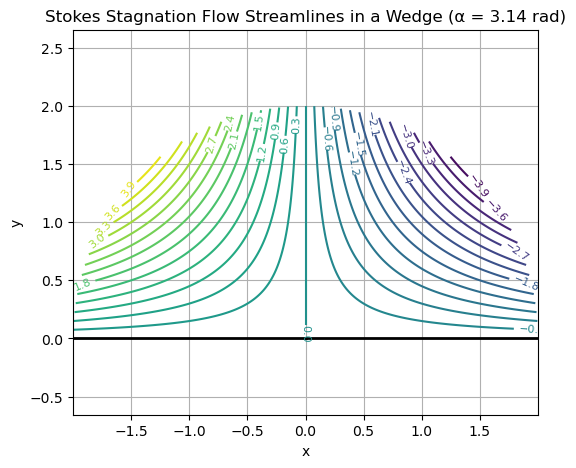

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
A = -1.0               # Streamfunction amplitude
alpha =3*np.pi / 4     # Wedge angle in radians (change as needed)

# Create polar grid
r = np.linspace(0.01, 2.0, 500)
theta = np.linspace(1e-3, alpha - 1e-3, 500)
R, Theta = np.meshgrid(r, theta)

# Compute streamfunction in polar coordinates
psi = A * R**(2 * np.pi / alpha) * np.sin((2 * np.pi / alpha) * Theta)

# Convert to Cartesian for plotting
X = R * np.cos(Theta)
Y = R * np.sin(Theta)

# Plot streamlines (contours of psi)
plt.figure(figsize=(6, 5))
contours = plt.contour(X, Y, psi, levels=30, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)
plt.title(f"Stokes Stagnation Flow Streamlines in a Wedge (α = {alpha:.2f} rad)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.grid(True)
plt.plot([0, plt.ylim()[1]], [0, 0], 'k-', lw=2)  # Wedge boundary
plt.plot([plt.xlim()[0], 0], [plt.xlim()[0]*np.tan(alpha), 0], 'k-', lw=2)  # Wedge boundary
plt.show()
